<a href="https://colab.research.google.com/github/himanshutyagi2020/Tensorflow/blob/main/Copy_of_Bayesian_BBN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pybbn

  Created wheel for pybbn: filename=pybbn-3.2.1-py3-none-any.whl size=39726 sha256=db030cdb0e6a1a4371201bbc870611443aeb2a936b8944686eadd0a034d731d5
  Stored in directory: /root/.cache/pip/wheels/a8/64/55/b52530d41fe7c9ae501ddd7c06f3122ceb5f15921680f0371b
Successfully built pybbn


In [ ]:
import pandas as pd # for data manipulation 
import networkx as nx # for drawing graphs
import matplotlib.pyplot as plt # for drawing graphs

# for creating Bayesian Belief Networks (BBN)
from pybbn.graph.dag import Bbn
from pybbn.graph.edge import Edge, EdgeType
from pybbn.graph.jointree import EvidenceBuilder
from pybbn.graph.node import BbnNode
from pybbn.graph.variable import Variable
from pybbn.pptc.inferencecontroller import InferenceController

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving engineering_1.csv to engineering_1.csv


In [ ]:
df=pd.read_csv('engineering_1.csv')
df.head(10)

,party,smart,innovative,assignment,laptop,project,goal,happy
0,0,1,1,1,1,0,0,0
1,1,1,0,1,1,1,1,1
2,0,1,1,1,1,1,1,0
3,0,1,1,1,0,1,1,1
4,1,1,0,0,1,1,1,1
5,0,1,1,1,1,1,1,0
6,1,1,1,1,1,1,1,1
7,1,1,1,1,1,1,1,1
8,1,0,1,0,0,1,0,0
9,1,1,1,0,1,1,0,1


In [ ]:
# This function helps to calculate probability distribution, which goes into BBN (note, can handle up to 2 parents)
def probs(data, child, parent1=None, parent2=None,parent3=None):
    if parent1==None:
        # Calculate probabilities
        prob=pd.crosstab(data[child], 'Empty', margins=False, normalize='columns').sort_index().to_numpy().reshape(-1).tolist()
    elif parent1!=None:
            # Check if child node has 1 parent or 2 parents
            if parent2==None:
                # Caclucate probabilities
                prob=pd.crosstab(data[parent1],data[child], margins=False, normalize='index').sort_index().to_numpy().reshape(-1).tolist()
            elif parent2!=None:
              # Check if child node has 1 parent or 2 parents
              if parent3==None:
                  # Caclucate probabilities
                  prob=pd.crosstab([data[parent1],data[parent2]],data[child], margins=False, normalize='index').sort_index().to_numpy().reshape(-1).tolist()
              else:    
                  # Caclucate probabilities
                  prob=pd.crosstab([data[parent1],data[parent2],data[parent3]],data[child], margins=False, normalize='index').sort_index().to_numpy().reshape(-1).tolist()            
    else: print("Error in Probability Frequency Calculations")
    return prob  

In [ ]:
# Create nodes by using our earlier function to automatically calculate probabilities
partyN = BbnNode(Variable(0, 'partyN', ['0', '1']), probs(df, child='party'))
smartN = BbnNode(Variable(1, 'smartN', ['0', '1']), probs(df, child='smart'))
innovativeN = BbnNode(Variable(2, 'innovativeN', ['0', '1']), probs(df, child='innovative'))
assignmentN = BbnNode(Variable(3, 'assignmentN', ['0', '1']), probs(df, child='assignment',parent1='party', parent2='smart'))
laptopN = BbnNode(Variable(4, 'laptopN', ['0', '1']), probs(df, child='laptop', parent1='smart', parent2='innovative'))
projectN = BbnNode(Variable(5, 'projectN', ['0', '1']), probs(df, child='project', parent1='smart', parent2='innovative'))
goalN = BbnNode(Variable(6, 'goalN', ['0', '1']), probs(df, child='goal', parent1='assignment', parent2='project'))
happyN = BbnNode(Variable(7, 'happyN', ['0', '1']), probs(df, child='happy', parent1='party', parent2='goal',parent3='laptop'))
# happyN = BbnNode(Variable(7, 'happyN', ['0', '1']), probs(df, child='happy', parent1='party', parent2='goal'))

In [ ]:
print(probs(df, child='party'))
print(probs(df, child='happy'))
print(probs(df, child='happy', parent1='party', parent2='goal',parent3='laptop'))
print(probs(df, child='project'))
print(probs(df, child='project', parent1='smart', parent2='innovative'))

[0.3978, 0.6022]
[0.4854, 0.5146]
[0.9061488673139159, 0.09385113268608414, 0.7950310559006211, 0.20496894409937888, 0.6931818181818182, 0.3068181818181818, 0.6420079260237781, 0.3579920739762219, 0.5798816568047337, 0.42011834319526625, 0.5076754385964912, 0.4923245614035088, 0.27848101265822783, 0.7215189873417721, 0.040625, 0.959375]
[0.2928, 0.7072]
[0.8944954128440367, 0.10550458715596331, 0.5971153846153846, 0.4028846153846154, 0.20618556701030927, 0.7938144329896907, 0.09483109483109484, 0.9051689051689051]


In [ ]:
# Create Network
bbn = Bbn() \
    .add_node(partyN) \
    .add_node(smartN) \
    .add_node(innovativeN) \
    .add_node(assignmentN) \
    .add_node(projectN) \
    .add_node(laptopN) \
    .add_node(goalN) \
    .add_node(happyN) \
    .add_edge(Edge(partyN, happyN, EdgeType.DIRECTED)) \
    .add_edge(Edge(goalN, happyN, EdgeType.DIRECTED)) \
    .add_edge(Edge(laptopN, happyN, EdgeType.DIRECTED)) \
    .add_edge(Edge(assignmentN, goalN, EdgeType.DIRECTED)) \
    .add_edge(Edge(projectN, goalN, EdgeType.DIRECTED)) \
    .add_edge(Edge(partyN, assignmentN, EdgeType.DIRECTED)) \
    .add_edge(Edge(smartN, assignmentN, EdgeType.DIRECTED)) \
    .add_edge(Edge(smartN, projectN, EdgeType.DIRECTED)) \
    .add_edge(Edge(smartN, laptopN, EdgeType.DIRECTED)) \
    .add_edge(Edge(innovativeN, projectN, EdgeType.DIRECTED)) \
    .add_edge(Edge(innovativeN, laptopN, EdgeType.DIRECTED))

In [ ]:
# Convert the BBN to a join tree
join_tree = InferenceController.apply(bbn)

(-1.32, 1.32, -2.22, 3.72)

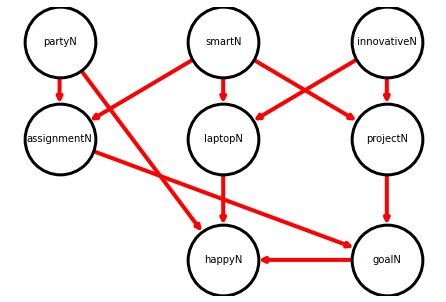

In [ ]:
# Set node positions
pos = {0: (-1, 3), 1: (0, 3), 2: (1, 3), 3: (-1, 1), 4: (0, 1), 5: (1, 1), 6: (1, -1.5), 7: (0,-1.5)}

# Set options for graph looks
options = {
    "font_size": 10,
    "node_size": 5000,
    "node_color": "white",
    "edgecolors": "black",
    "edge_color": "red",
    "linewidths": 3,
    "width": 4,}
    
# Generate graph
n, d = bbn.to_nx_graph()
nx.draw(n, with_labels=True, labels=d, pos=pos, **options)

# Update margins and print the graph
ax = plt.gca()
ax.margins(0.10)
plt.axis("off")
# plt.show()

In [ ]:
def print_probs():
    for node in join_tree.get_bbn_nodes():
        potential = join_tree.get_bbn_potential(node)
        print("Node:", node)
        print("Values:")
        print(potential)
        print('----------------')
        
# Use the above function to print marginal probabilities
print_probs()

Node: 0|partyN|0,1
Values:
0=0|0.39780
0=1|0.60220
----------------
Node: 4|laptopN|0,1
Values:
4=0|0.37837
4=1|0.62163
----------------
Node: 6|goalN|0,1
Values:
6=0|0.44280
6=1|0.55720
----------------
Node: 7|happyN|0,1
Values:
7=0|0.47085
7=1|0.52915
----------------
Node: 1|smartN|0,1
Values:
1=0|0.29520
1=1|0.70480
----------------
Node: 5|projectN|0,1
Values:
5=0|0.29309
5=1|0.70691
----------------
Node: 2|innovativeN|0,1
Values:
2=0|0.30060
2=1|0.69940
----------------
Node: 3|assignmentN|0,1
Values:
3=0|0.35493
3=1|0.64507
----------------


In [ ]:

# To add evidence of events that happened so probability distribution can be recalculated
def evidence(ev, nod, cat, val):
    ev = EvidenceBuilder() \
    .with_node(join_tree.get_bbn_node_by_name(nod)) \
    .with_evidence(cat, val) \
    .build()
    join_tree.set_observation(ev)
    
# Use above function to add evidence
# evidence('ev1', 'happyN', '1', 1.0)
evidence('ev1', 'projectN', '1', 1.0)


# Print marginal probabilities
print_probs()

Node: 0|partyN|0,1
Values:
0=0|0.20497
0=1|0.79503
----------------
Node: 4|laptopN|0,1
Values:
4=0|0.23227
4=1|0.76773
----------------
Node: 6|goalN|0,1
Values:
6=0|0.24374
6=1|0.75626
----------------
Node: 7|happyN|0,1
Values:
7=0|0.00000
7=1|1.00000
----------------
Node: 1|smartN|0,1
Values:
1=0|0.13000
1=1|0.87000
----------------
Node: 5|projectN|0,1
Values:
5=0|0.00000
5=1|1.00000
----------------
Node: 2|innovativeN|0,1
Values:
2=0|0.21933
2=1|0.78067
----------------
Node: 3|assignmentN|0,1
Values:
3=0|0.24330
3=1|0.75670
----------------
